In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [6]:
## Loading in the extracted, normalized, binned spectral lighcurves
## from my 'Extracting the Transmission Spectra time series' notebook
#tsdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/normalizedSpectralTimeSeries.npz')
tsdata = np.load('./Transit_Spectra_NoFirst_Visit3.npz')
times = tsdata['time']
t_visit = times - times[0]
rawfluxes = tsdata['flux']
rawerrors = tsdata['error']
scandirs = tsdata['scandir']
#waves = tsdata['wavelengths']
    
# Pull out times [in day; MJD] of each orbit
orbit_ends = np.array([17, 34, 51])
orbit2times = times[:orbit_ends[0]]
orbit3times = times[orbit_ends[0] : orbit_ends[1]]
orbit4times = times[orbit_ends[1] : orbit_ends[2]]

# From above, compute time since beginning of orbit for each
tinorbit2 = orbit2times - orbit2times[0]
tinorbit3 = orbit3times - orbit3times[0]
tinorbit4 = orbit4times - orbit4times[0]
t_orbit = np.concatenate((tinorbit2, tinorbit3, tinorbit4))

fluxes = np.copy(rawfluxes)
errors = np.copy(rawerrors)
Nbins = rawfluxes.shape[0]
for wav in range(Nbins):
    # normalizing thomas'
    sd1_idxs = np.where(scandirs == 1.)[0]
    sd0_idxs = np.where(scandirs == 0.)[0]
    
    # if normalizing by max flux in second orbit:
#     orbit2_sd1 = rawfluxes[wav,:][sd1_idxs][:8]
#     orbit2_sd0 = rawfluxes[wav,:][sd0_idxs][:8]
#     normval1, normval0 = np.max(orbit2_sd1), np.max(orbit2_sd0)
    # if normalizing by median flux of whole visit
    normval1 = np.median(fluxes[wav, sd1_idxs])
    normval0 = np.median(fluxes[wav, sd0_idxs])
    
    fluxes[wav, sd1_idxs] /= normval1
    errors[wav, sd1_idxs] /= normval1
    fluxes[wav, sd0_idxs] /= normval0
    errors[wav, sd0_idxs] /= normval0

errors /= 3.0
    
Npoints = fluxes.shape[1]
Nwaves = fluxes.shape[0]

In [7]:
print('Average flux error = %d ppm'%(np.mean(errors*1.e6)))

Average flux error = 193 ppm


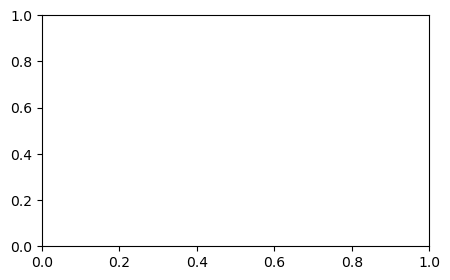

In [4]:
fig, ax = plt.subplots(figsize=(5,3))
#ax.scatter(t_orbit, fluxes[0,:])
#ax.scatter(t_visit, fluxes[0,:])
#ax.scatter(t_visit[17:34], fluxes[0,17:34], c='red')
plt.show()

In [8]:
##
# Defining my parameter arrays (inits, priors, etc)
# I'll fix all of the orbital parameters to values gotten from my broadband fitting
# Here, I'll only fit the transit depths and systematic parameters
# I should also look into using single systematics based on broadband fitting too
rprs_init, rprs_init_unc = 0.0439177, 0.00027693

t0_fixed = 2458329.200100647 #2458329.201974941  # [day]
P_fixed =  10. ** 0.780638562833854 #6.03447168385       # [day]
a_fixed = 10. ** 1.1200598308963605 #13.4136             # [Rs]
inc_fixed = (180. / np.pi) * np.arccos(np.fabs(0.06440772705532975)) #86.4225           # [degrees]
ecc_fixed = 0.
w_fixed = 90.
u_fixed = [0.058, 0.349] #[0.33, 0.2]

amplitude_o2_init, amperr_o2_init = 0.0022, 0.01
amplitude_o3_init, amperr_o3_init = 0.0012, 0.01
    
tau_o2_init, tauerr_o2_init = -0.007, 0.01
tau_o3_init, tauerr_o3_init = -0.005,0.01

slope_init, slopeerr_init = -0.0065, 0.01
intcpt_init, intcpterr_init =  1.0000+0.0011, 0.01

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = t0_fixed     
InitParams.per = P_fixed
InitParams.a = a_fixed
InitParams.inc = inc_fixed
InitParams.rp = rprs_init
InitParams.ecc = ecc_fixed
InitParams.w = w_fixed
InitParams.limb_dark = 'quadratic'
InitParams.u = u_fixed
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [9]:
##
# Defining my astrophysical models

def transit(rprs, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = t0_fixed       # time of conjunction [days]
    P = P_fixed  # compute Period in [day]
    a = a_fixed  # compute a/Rstar
    inc = inc_fixed  # Compute inclination in [deg]
    ecc = ecc_fixed    # use these if assuming circular orbit
    omega = w_fixed
    rprstar = np.copy(rprs)
        
    # Set batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    params.limb_dark = 'quadratic'
    params.u = u_fixed
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve



##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude2 = theta[1]
    amplitude3 = theta[2]
    tau2 = theta[3]
    tau3 = theta[4]
    
    hookcurve = np.zeros(len(t_orbit))
    hookcurve[:17] = 1. - amplitude2*np.exp(t_orbit[:17]/tau2)
    hookcurve[17:] = 1. - amplitude3*np.exp(t_orbit[17:]/tau3)
    return hookcurve

def ramp(theta):
    # Visit-long linear model for flux in time
    slope = theta[5]
    intercept = theta[6]
    
    y = intercept + (slope*t_visit)
    return y

In [10]:
def logLikelihood(ydata, yerr, modely):
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    
    return lnL

def logPriors(theta):
    priors = mc_priors
    priorserr = mc_priorserr
    
    # Limits on certain parameters
    if not (0. <= theta[0] <= 1.): return -np.inf
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            lnP += 0 #continue
        else:
            lnP += -(theta[i] - priorval) ** 2. / (2. * priorserr[i] ** 2.) - np.log(np.sqrt(2. * priorserr[i] **2. * np.pi))
            #-0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    return lnP

def lnPosterior(theta):
    
    prior_array = mc_priors
    priorerrs_array = mc_priorserr
    flux_array = mc_flux
    unc_array = mc_errs
        
    tran_model = transit(theta[0], BATMAN_initmodel)
    hook_model = hook(theta)
    ramp_model = ramp(theta)
    model = tran_model * hook_model * ramp_model
        
    lnlikelihood = logLikelihood(mc_flux, mc_errs, model)
    
#     # Compute and check priors
    lnPrior_value = logPriors(theta)
#     if not np.isfinite(lnPrior_value):
#         return -np.inf

    # Compute posterior
    lnPost = lnlikelihood + lnPrior_value
    
    if (np.isnan(lnPost)):
        return -np.inf
    else:
        return lnPost

In [11]:
res = {
    'spec0':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec1':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec2':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec3':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec4':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec5':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec6':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec7':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec8':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec9':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec10':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec11':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec12':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec13':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec14':{
        'fits': np.array([]),
        'errs': np.array([])
    }
}

In [12]:
Nburn = 1000
Nsteps = 4000


for wav in range(Nwaves):
    print('on bin ', wav)
    # set up initial values and priors
    theta_init = np.array([rprs_init, amplitude_o2_init, amplitude_o3_init, tau_o2_init, tau_o3_init, slope_init, intcpt_init])
    priorerrs = np.array([rprs_init_unc, amperr_o2_init, amperr_o3_init, tauerr_o2_init, tauerr_o3_init, slopeerr_init, intcpterr_init])
    # define mcmc global inputs
    mc_flux, mc_errs = fluxes[wav,:], errors[wav,:]
    mc_priors = np.array([np.inf, amplitude_o2_init, amplitude_o3_init, tau_o2_init, tau_o3_init, slope_init, intcpt_init])
    mc_priorserr = np.copy(priorerrs)
    # compute initial posterior
    lnPost_init = lnPosterior(theta_init)
    print(lnPost_init)
    
    # Setting up and initializing MCMC
    Ndimensions = len(theta_init)
    Nwalkers = 2*Ndimensions

    # Initializing walker positions
    pos = np.zeros((Nwalkers, Ndimensions))
    for i in range(Ndimensions):
        pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorerrs[i], Nwalkers)
    print('running burn-in')
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
        sampler.run_mcmc(pos, Nburn, progress=True);
        
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)
    burn = int(Nburn-100)
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]

    burn_vals = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    burn_err = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - burn_vals
    
    pos = np.zeros((Nwalkers, Ndimensions))
    for i in range(Ndimensions):
        pos[:,i] = burn_vals[i] + 0.5*np.random.normal(0., burn_err[i], Nwalkers)
    print('running mcmc')
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
        sampler.run_mcmc(pos, Nsteps, progress=True);\
        
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)

    burn = 0
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]

    param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
    param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])
    gausserrs = np.mean((param_uperrs, param_loerrs), axis=0)
    
    depth_chain = flatsamples[:,0] ** 2.
    depth_fit = np.median(depth_chain)
    depth_uperr = np.percentile(depth_chain, 84) - depth_fit
    depth_loerr = depth_fit - np.percentile(depth_chain, 16)
    depth_err = np.mean((depth_uperr, depth_loerr))
    param_fits = np.append(param_fits, depth_fit)
    gausserrs = np.append(gausserrs, depth_err)
    
    
    res['spec'+str(wav)]['fits'] = param_fits
    res['spec'+str(wav)]['errs'] = gausserrs

on bin  0
306.30258613369926
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 601.64it/s]


running mcmc


100%|██████████| 4000/4000 [00:06<00:00, 637.00it/s]

on bin  1
260.06629216204266
running burn-in



100%|██████████| 1000/1000 [00:01<00:00, 629.50it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 634.70it/s]


on bin  2
261.51425401921483
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 633.16it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 638.05it/s]


on bin  3
309.89534440851764
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 635.00it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 637.09it/s]


on bin  4
378.44079960752293
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 630.30it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 631.79it/s]

on bin  5
342.732739154657
running burn-in



100%|██████████| 1000/1000 [00:01<00:00, 632.11it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 637.41it/s]


on bin  6
376.49430670448976
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 630.09it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 631.42it/s]

on bin  7
385.37313786709126
running burn-in



100%|██████████| 1000/1000 [00:01<00:00, 630.67it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 635.26it/s]


on bin  8
381.35140593643024
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 629.43it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 628.84it/s]

on bin  9
382.1668922371446
running burn-in



100%|██████████| 1000/1000 [00:01<00:00, 628.47it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 633.00it/s]

on bin  10
289.26466897689505
running burn-in



100%|██████████| 1000/1000 [00:01<00:00, 635.36it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 636.70it/s]

on bin  11
376.95053042090984
running burn-in



100%|██████████| 1000/1000 [00:01<00:00, 632.63it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 635.92it/s]


on bin  12
375.75086973650326
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 635.10it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 629.41it/s]

on bin  13
366.9763705233006
running burn-in



100%|██████████| 1000/1000 [00:01<00:00, 624.05it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 635.60it/s]


on bin  14
362.1981266729856
running burn-in


100%|██████████| 1000/1000 [00:01<00:00, 628.03it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 632.50it/s]


In [14]:
#res

In [13]:
depths = np.zeros(Nwaves)
deptherrs = np.copy(depths)
for wav in range(Nwaves):
    rprs = res['spec'+str(wav)]['fits'][0]
    err = res['spec'+str(wav)]['errs'][0]
    
    depth = rprs**2
    derr = depth*(err/rprs)*np.sqrt(2)
    depths[wav] = depth
    deptherrs[wav] = derr
    

    print('Wavelength bin %d'%(wav))
    print('Depth = %d +/- %d ppm'%(depth*1.e6, derr*1.e6))
print('\n')
print('Average depth error = %d ppm'%(np.mean(deptherrs*1.e6)))    

Wavelength bin 0
Depth = 1599 +/- 171 ppm
Wavelength bin 1
Depth = 1552 +/- 179 ppm
Wavelength bin 2
Depth = 1618 +/- 158 ppm
Wavelength bin 3
Depth = 1555 +/- 66 ppm
Wavelength bin 4
Depth = 1775 +/- 67 ppm
Wavelength bin 5
Depth = 1751 +/- 90 ppm
Wavelength bin 6
Depth = 1652 +/- 50 ppm
Wavelength bin 7
Depth = 1926 +/- 60 ppm
Wavelength bin 8
Depth = 1982 +/- 60 ppm
Wavelength bin 9
Depth = 1951 +/- 57 ppm
Wavelength bin 10
Depth = 1988 +/- 108 ppm
Wavelength bin 11
Depth = 1875 +/- 63 ppm
Wavelength bin 12
Depth = 1900 +/- 51 ppm
Wavelength bin 13
Depth = 1860 +/- 54 ppm
Wavelength bin 14
Depth = 1860 +/- 59 ppm


Average depth error = 86 ppm


In [14]:
store = False
if store:
    mp_td_depths = np.copy(depths)
    mp_td_deptherrs = np.copy(deptherrs)
    %store mp_td_depths
    %store mp_td_deptherrs

In [18]:
%store -r tp_td_depths
%store -r tp_td_deptherrs

for wav in range(Nwaves):
    print('Wavelength bin %d'%(wav))
    print('Depth = %d +/- %d ppm'%(tp_td_depths[wav]*1.e6, tp_td_deptherrs[wav]*1.e6))

print('\n')
print('Average depth error = %d ppm'%(np.mean(tp_td_deptherrs*1.e6)))  

Wavelength bin 0
Depth = 1576 +/- 220 ppm
Wavelength bin 1
Depth = 1522 +/- 223 ppm
Wavelength bin 2
Depth = 1559 +/- 207 ppm
Wavelength bin 3
Depth = 1554 +/- 68 ppm
Wavelength bin 4
Depth = 1760 +/- 68 ppm
Wavelength bin 5
Depth = 1746 +/- 95 ppm
Wavelength bin 6
Depth = 1653 +/- 50 ppm
Wavelength bin 7
Depth = 1911 +/- 60 ppm
Wavelength bin 8
Depth = 1974 +/- 62 ppm
Wavelength bin 9
Depth = 1945 +/- 56 ppm
Wavelength bin 10
Depth = 2033 +/- 175 ppm
Wavelength bin 11
Depth = 1860 +/- 62 ppm
Wavelength bin 12
Depth = 1893 +/- 55 ppm
Wavelength bin 13
Depth = 1858 +/- 55 ppm
Wavelength bin 14
Depth = 1860 +/- 59 ppm


Average depth error = 101 ppm


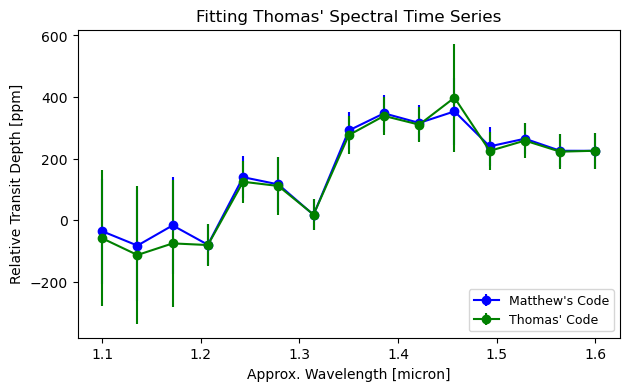

In [21]:
fig, ax = plt.subplots(figsize=(7,4))
waves = np.linspace(1.1, 1.6, Nwaves)

med_depth = np.median(depths[np.where(waves <= 1.35)[0]]) * 1.e6

ax.set_title("Fitting Thomas' Spectral Time Series")
ax.errorbar(waves, depths*1.e6 - med_depth, yerr=deptherrs*1.e6, c='blue', marker='o', label="Matthew's Code")
ax.errorbar(waves, tp_td_depths*1.e6 - med_depth, yerr=tp_td_deptherrs*1.e6, c='green', marker='o', label="Thomas' Code")
ax.legend(loc='lower right', fontsize=9)
ax.set_xlabel('Approx. Wavelength [micron]')
ax.set_ylabel('Relative Transit Depth [ppm]')
plt.show()

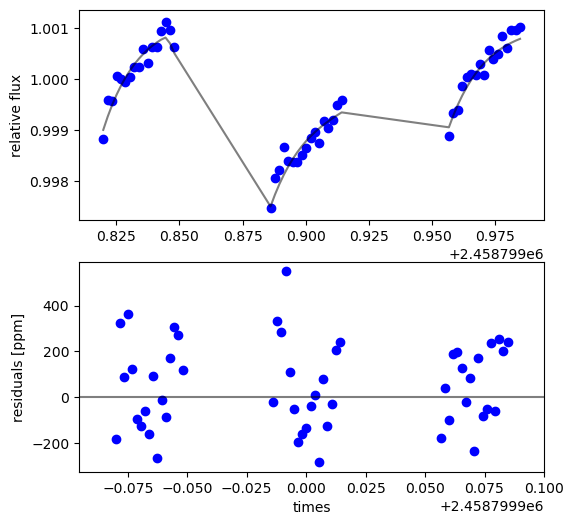

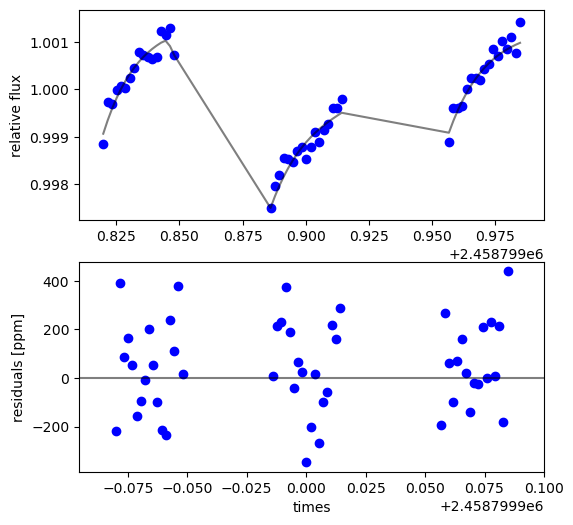

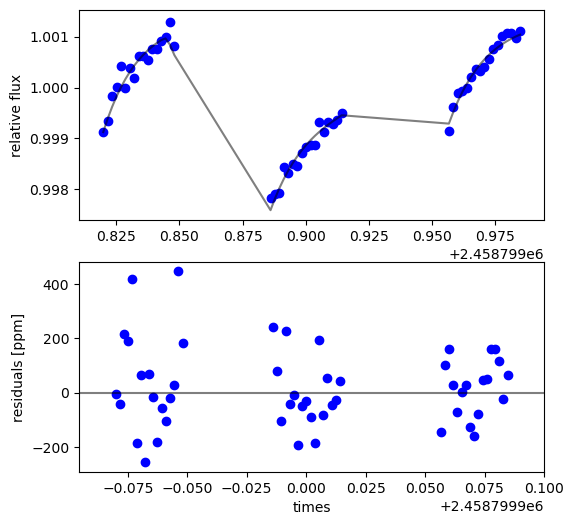

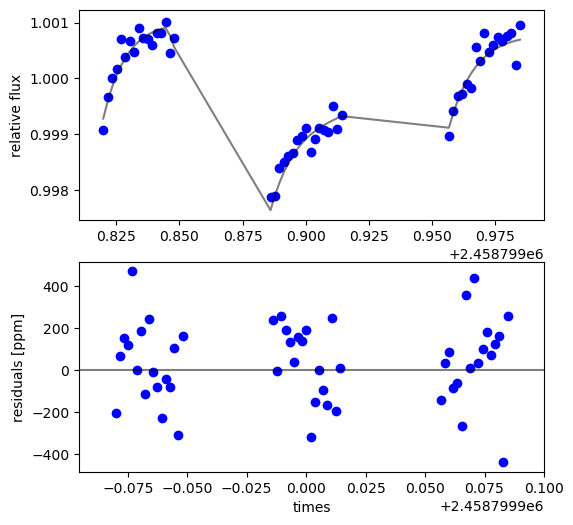

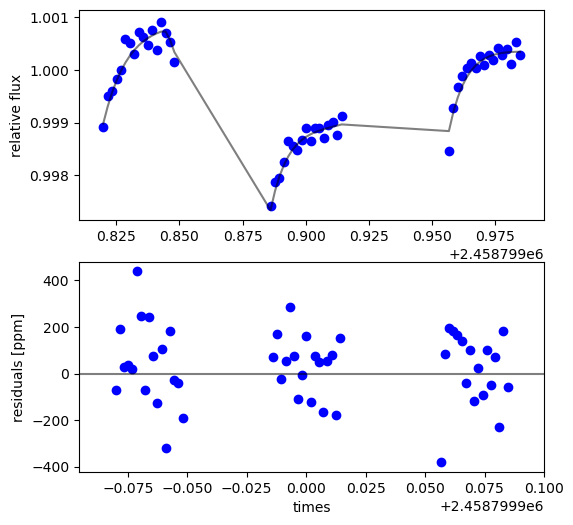

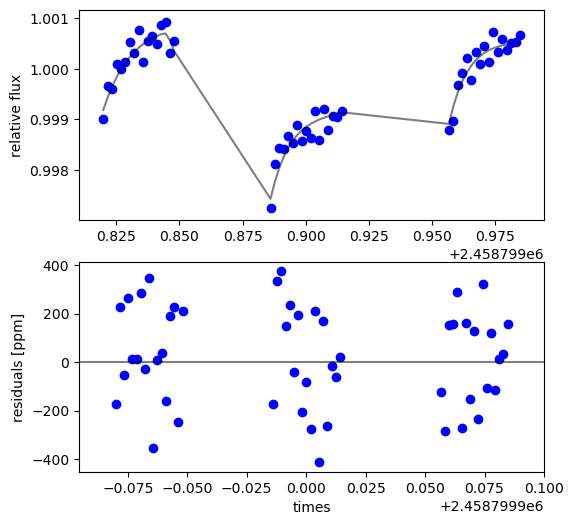

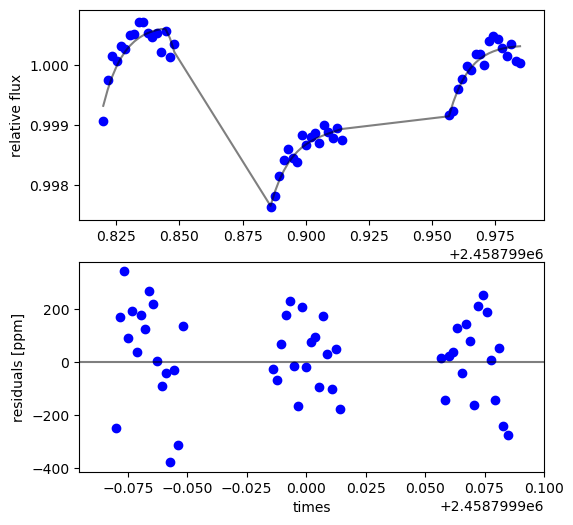

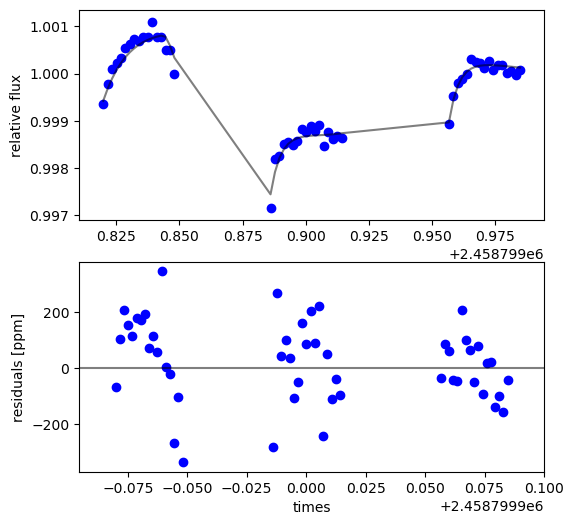

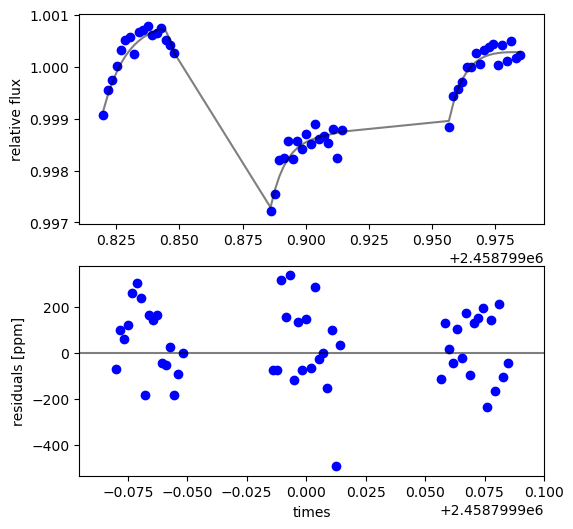

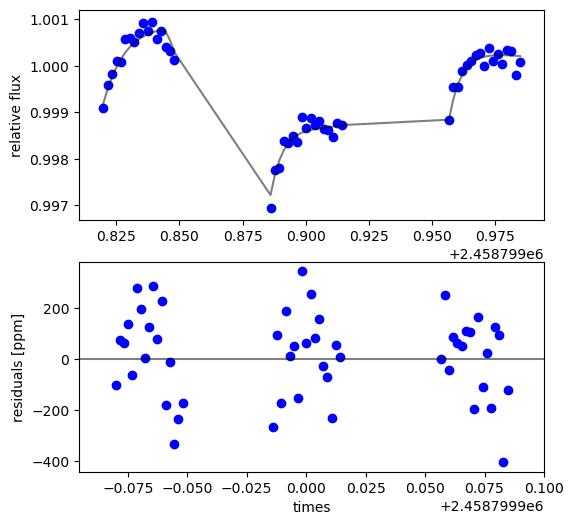

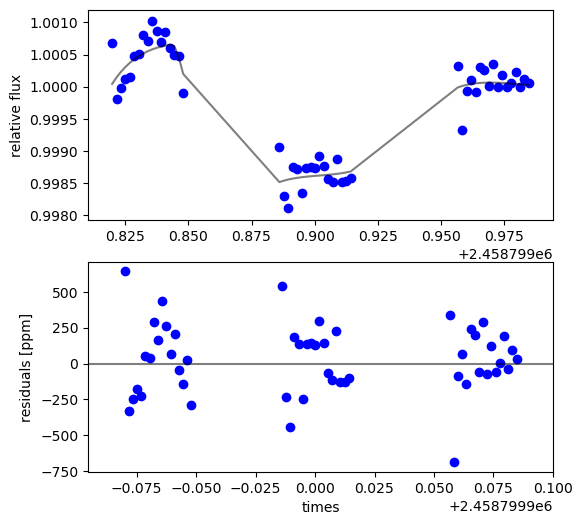

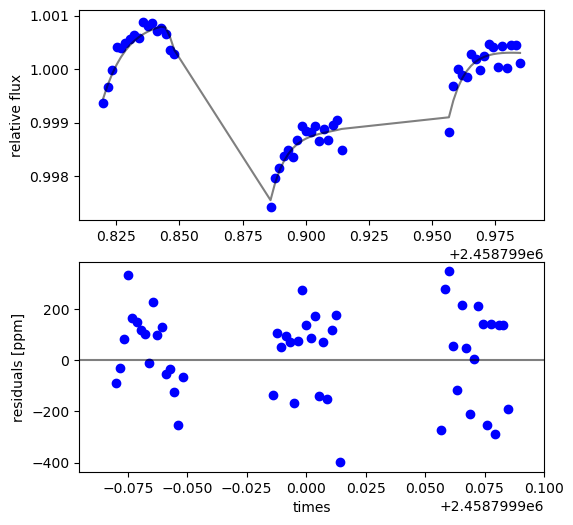

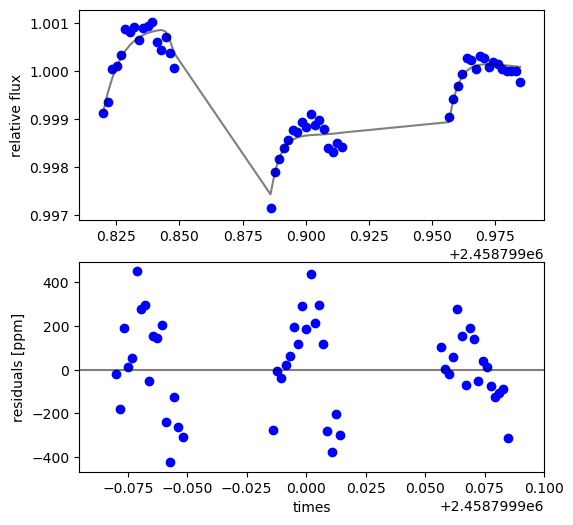

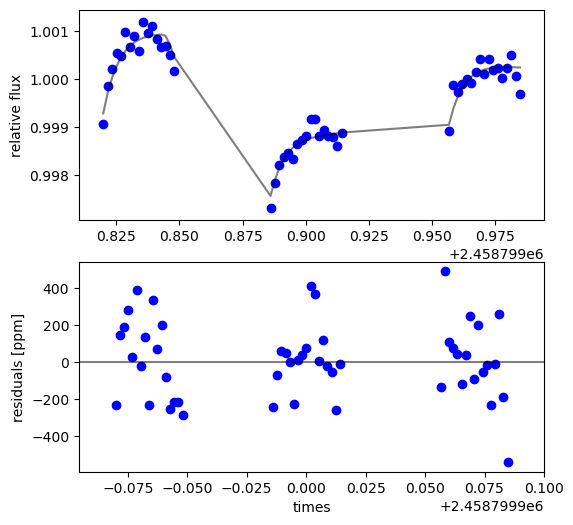

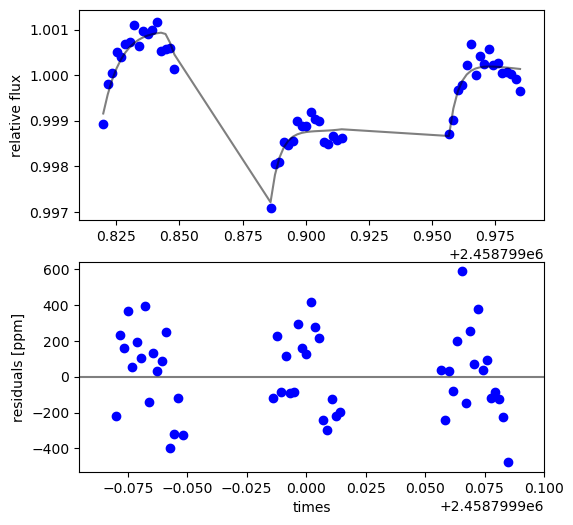

In [14]:
# Plotting raw light curves
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_initmodel)
    hoo = hook(params)
    ram = ramp(params)
    model = tran * hoo * ram
    resids = fluxes[wav, :] - model
    
    fig, ax = plt.subplots(figsize=(6,6), nrows=2)
    # plotting the flux data and model
    ax[0].plot(times, model, c='black', alpha=0.5)
    ax[0].scatter(times, fluxes[wav,:], c='blue')
    ax[0].set_ylabel('relative flux')
    # plotting the residuals
    ax[1].axhline(0., c='black', alpha=0.5)
    ax[1].scatter(times, resids*1.e6, c='blue')
    ax[1].set_ylabel('residuals [ppm]')
    ax[1].set_xlabel('times')
    plt.show()

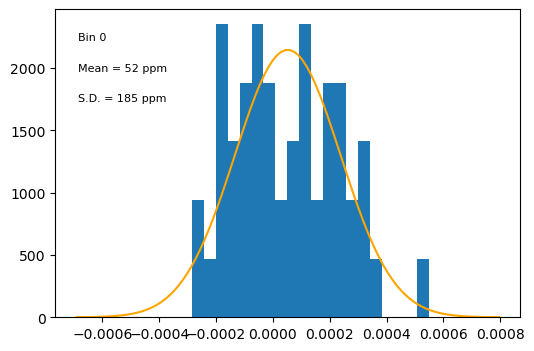

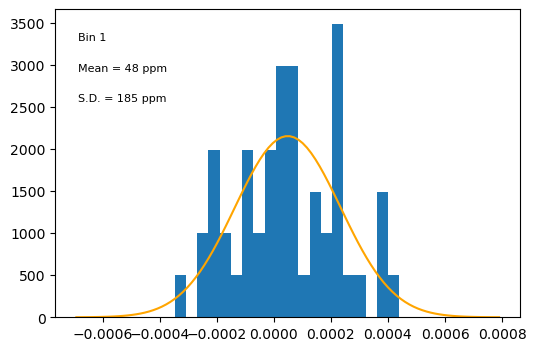

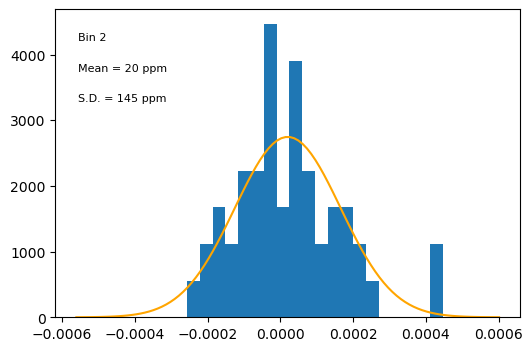

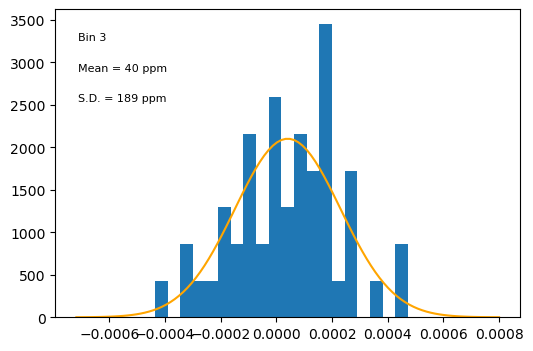

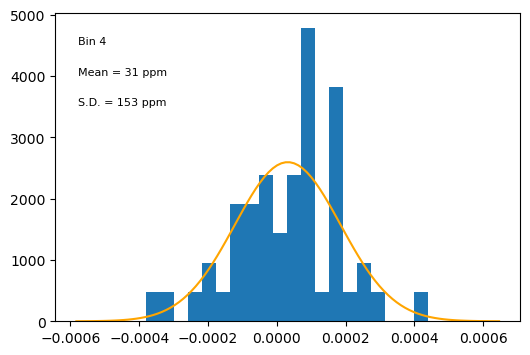

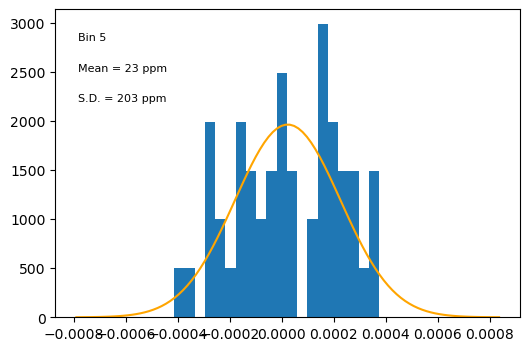

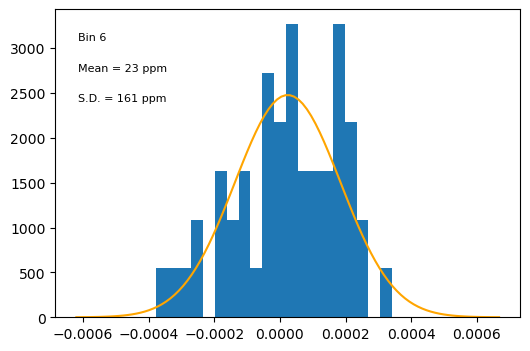

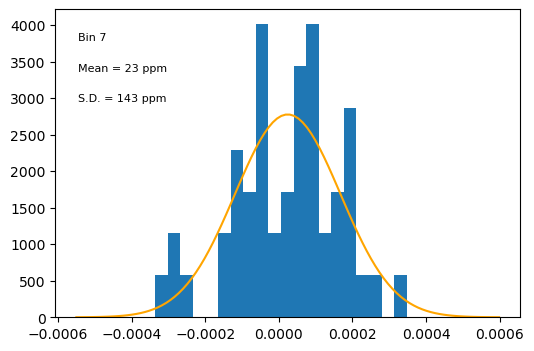

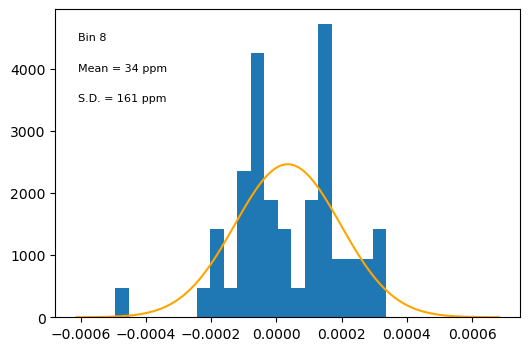

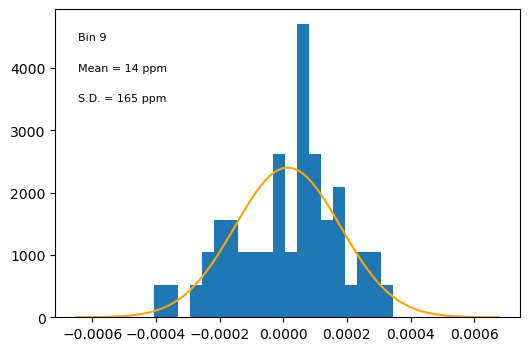

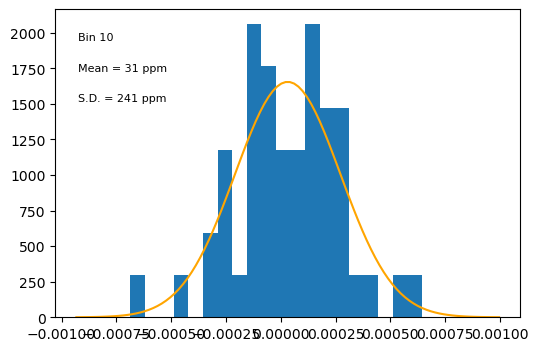

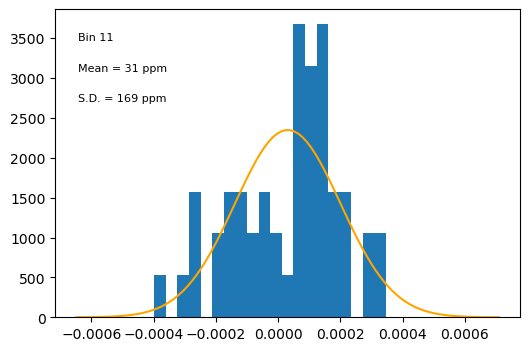

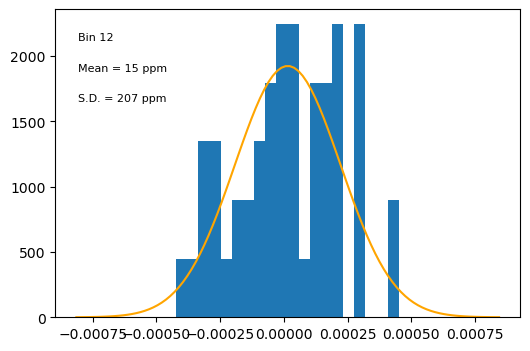

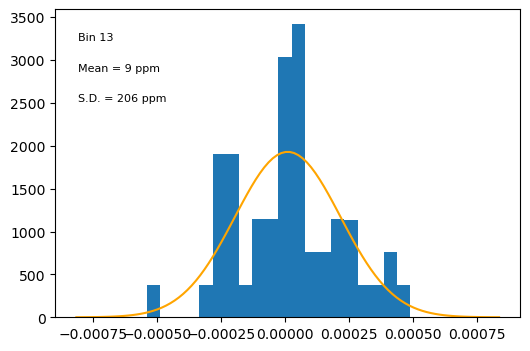

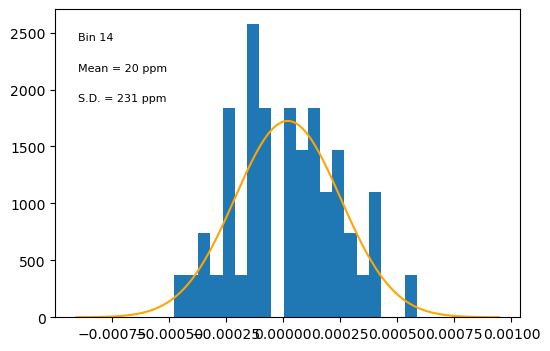

In [17]:
# plotting and fitting the residuals
residual_sd_vals = np.zeros(Nwaves)
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_initmodel)
    hoo = hook(params)
    ram = ramp(params)
    model = tran * hoo * ram
    resids = fluxes[wav, :] - model
    
    mu, sd = norm.fit(resids)
    residual_sd_vals[wav] = sd
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(resids, bins=20, density=True)
    xpdf = np.linspace((mu-4.*sd), (mu+4.*sd), 100)
    ypdf = norm.pdf(xpdf, mu, sd)
    ax.plot(xpdf, ypdf, c='orange')
    ax.text(0.05, 0.9, 'Bin %d'%(wav), c='black', fontsize=8, transform=ax.transAxes)
    ax.text(0.05, 0.8, 'Mean = %d ppm'%(mu*1.e6), c='black', fontsize=8, transform=ax.transAxes)
    ax.text(0.05, 0.7, 'S.D. = %d ppm'%(sd*1.e6), c='black', fontsize=8, transform=ax.transAxes)
    plt.show()
    
    
    
#     fig, ax = plt.subplots(figsize=(6,6), nrows=2)
#     # plotting the flux data and model
#     ax[0].plot(times, model, c='black', alpha=0.5)
#     ax[0].scatter(times, fluxes[wav,:], c='blue')
#     ax[0].set_ylabel('relative flux')
#     # plotting the residuals
#     ax[1].axhline(0., c='black', alpha=0.5)
#     ax[1].scatter(times, resids*1.e6, c='blue')
#     ax[1].set_ylabel('residuals [ppm]')
#     ax[1].set_xlabel('times')
#     plt.show()

In [18]:
resid_level = np.mean(residual_sd_vals)
print('Residual level = %d ppm'%(resid_level*1.e6))

Residual level = 183 ppm


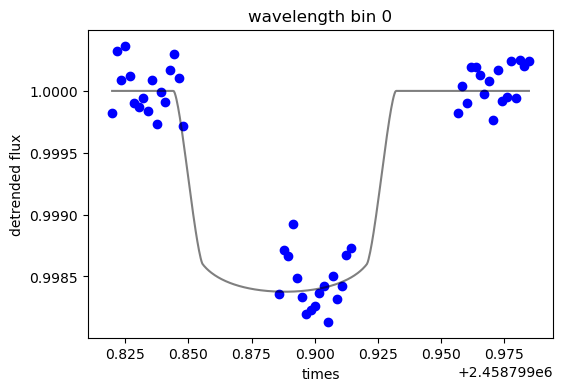

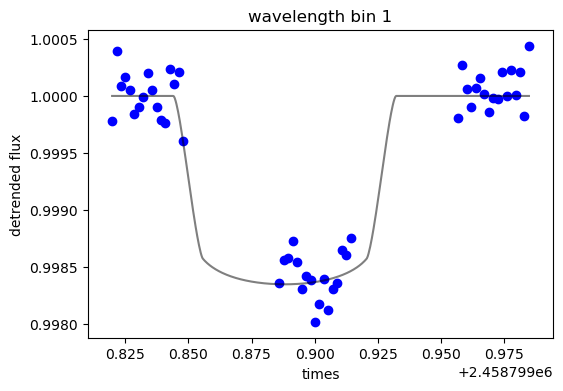

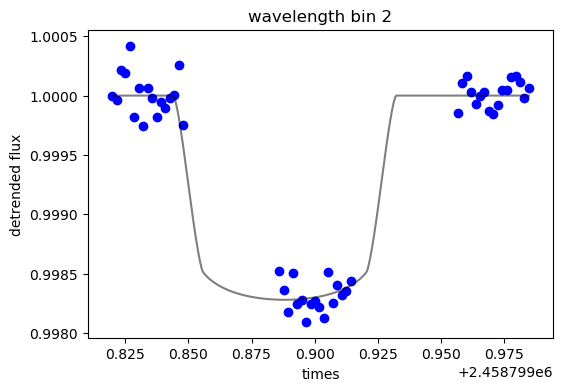

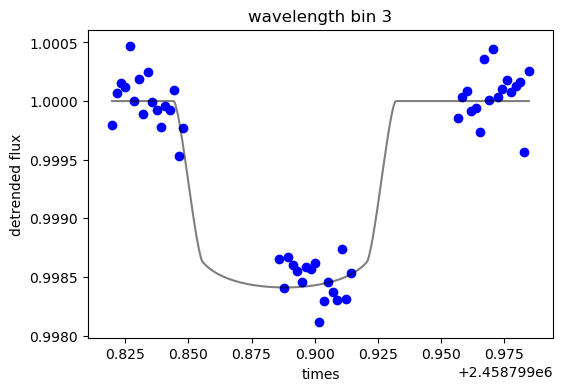

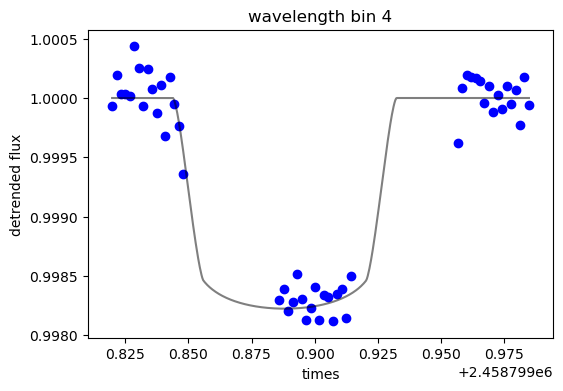

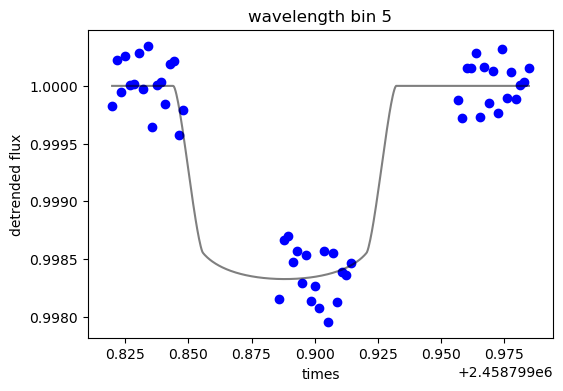

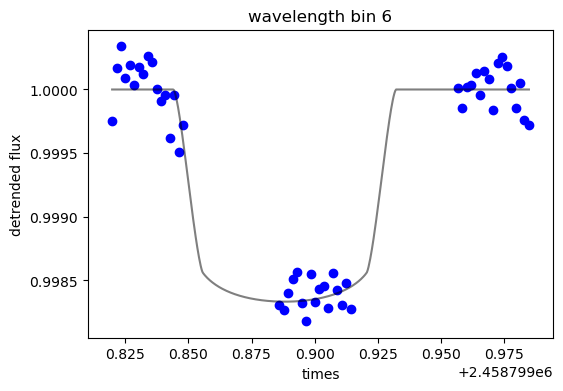

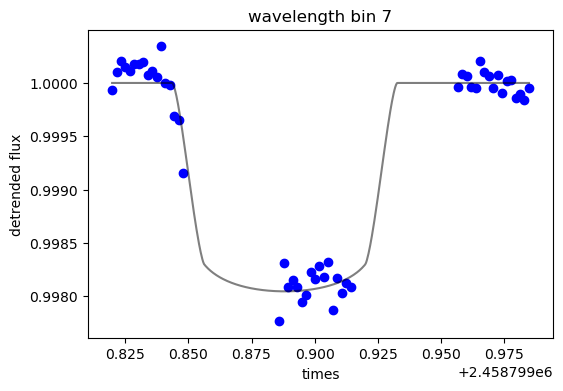

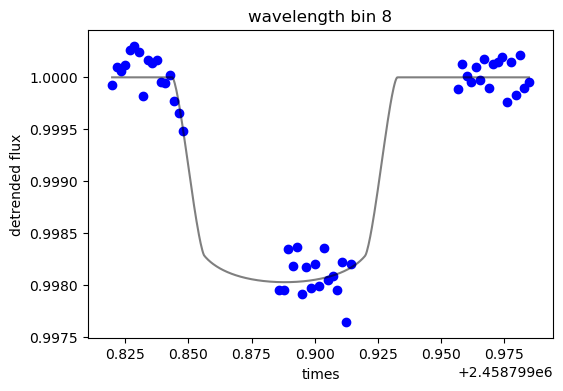

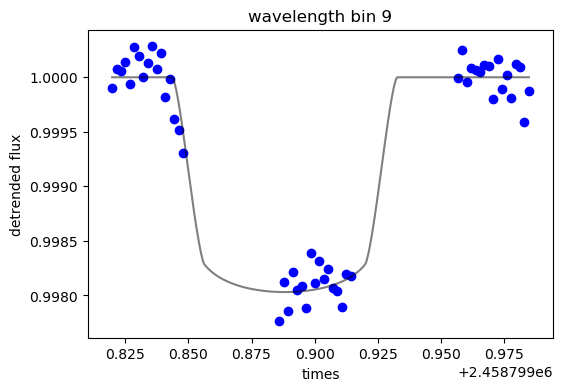

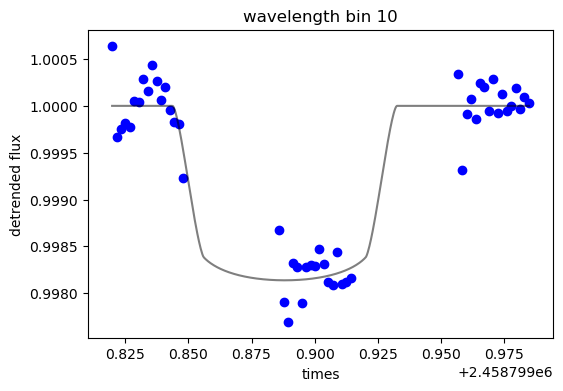

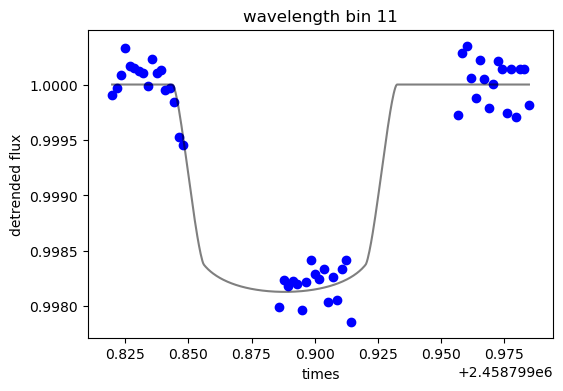

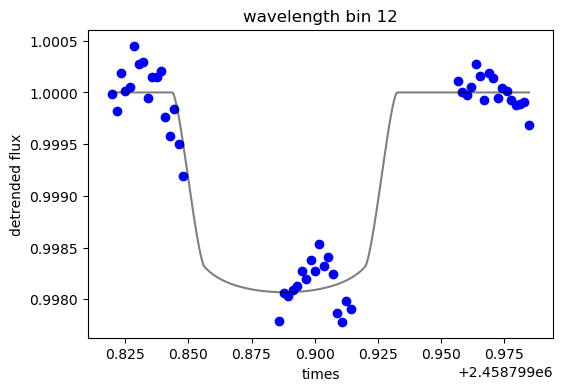

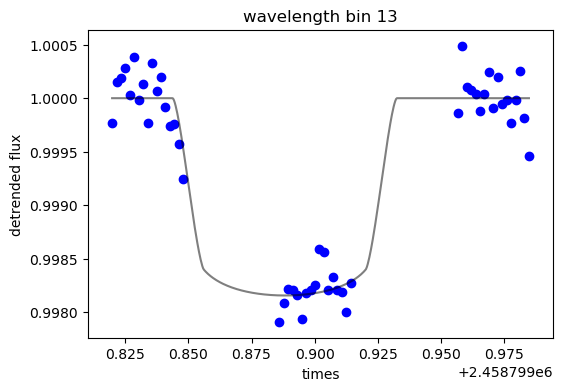

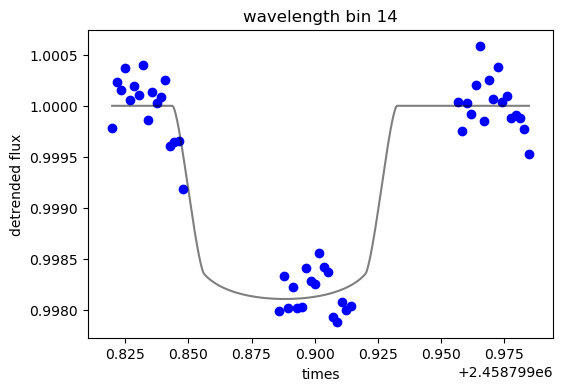

In [20]:
# Plotting detrended light curves
# Initializing the BATMAN model
PlottingParams = batman.TransitParams()
PlottingParams.t0 = t0_fixed     
PlottingParams.per = P_fixed
PlottingParams.a = a_fixed
PlottingParams.inc = inc_fixed
PlottingParams.rp = rprs_init
PlottingParams.ecc = ecc_fixed
PlottingParams.w = w_fixed
PlottingParams.limb_dark = 'quadratic'
PlottingParams.u = u_fixed
times_for_plotting = np.linspace(times[0], times[-1], 500)
BATMAN_plotmodel = batman.TransitModel(PlottingParams, times_for_plotting)

for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_plotmodel)
    hoo = hook(params)
    ram = ramp(params)
    systematics = hoo * ram
    det_flux = fluxes[wav,:] / systematics
    
    #model = tran * hoo * ram
    #resids = fluxes[wav, :] - model
    
    fig, ax = plt.subplots(figsize=(6,4))
    # plotting the flux data and model
    ax.plot(times_for_plotting, tran, c='black', alpha=0.5)
    ax.scatter(times, det_flux, c='blue')
    ax.set_ylabel('detrended flux')
    ax.set_xlabel('times')
    plt.title('wavelength bin %d'%(wav))
    plt.show()